# The `Path` class
## Polynomial borehole trajectories

geothermsim uses polynomial approximations for the trajectories of boreholes. Positions $\vec{p}$ along the length of a borehole are expressed as a polynomial function of degree $M-1$ of the coordinate $\xi$:
$$
\vec{p}(\xi) = \vec{a}_0 + \vec{a}_1 \cdot \xi + \vec{a}_2 \cdot \xi^2 + \cdots + \vec{a}_{M-1} \cdot \xi^{M-1}
$$
where the coeficients $\vec{a}_m$ are obtained by a polynomial regression of known positions along the borehole.

In [1]:
# Import necessary packages
import geothermsim as gs

import jax
from jax import numpy as jnp
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np

## Straight inclined path
The `Path` class can be instantiated given node coordinates and their associated position along the path.

For example, for a straight borehole of length $L=150$ m, burried at a distance $D=4$, inclined at an angle $\beta=10\degree$ and an orientation of $\theta=45\degree$ from the $x$-axis, located at position $(x=5, y=-2)$:

In [2]:
L = 150.  # Borehole length
D = 4.    # Borehole burried depth
beta = jnp.radians(10.)
theta = jnp.radians(45.)
(x, y) = (5., -2.)

The borehole path can be defined from the top ($\xi=-1$) and bottom ($\xi=1$) ends of the borehole:

In [3]:
xi = jnp.array([-1., 1.])
p = jnp.array(
    [
        [x, y, -D],
        [
            x + L * jnp.sin(beta) * jnp.cos(theta),
            y + L * jnp.sin(beta) * jnp.sin(theta),
            -D - L * jnp.cos(beta)
        ],
    ])

path = gs.Path(xi, p)

The position at any coordinate $\xi$ along the trajectory can be evaluated using the `Path.f_p` class method:

In [4]:
_xi = jnp.linspace(-1., 1., num=11)
path.f_p(_xi)

Array([[   5.        ,   -2.        ,   -4.        ],
       [   6.8418174 ,   -0.15818262,  -18.77212   ],
       [   8.683634  ,    1.6836338 ,  -33.54423   ],
       [  10.525451  ,    3.525451  ,  -48.31635   ],
       [  12.367268  ,    5.3672676 ,  -63.088463  ],
       [  14.2090845 ,    7.2090845 ,  -77.86058   ],
       [  16.050901  ,    9.050901  ,  -92.6327    ],
       [  17.892717  ,   10.892718  , -107.40481   ],
       [  19.734535  ,   12.734535  , -122.17693   ],
       [  21.576353  ,   14.576353  , -136.94905   ],
       [  23.418169  ,   16.418169  , -151.72116   ]], dtype=float32)

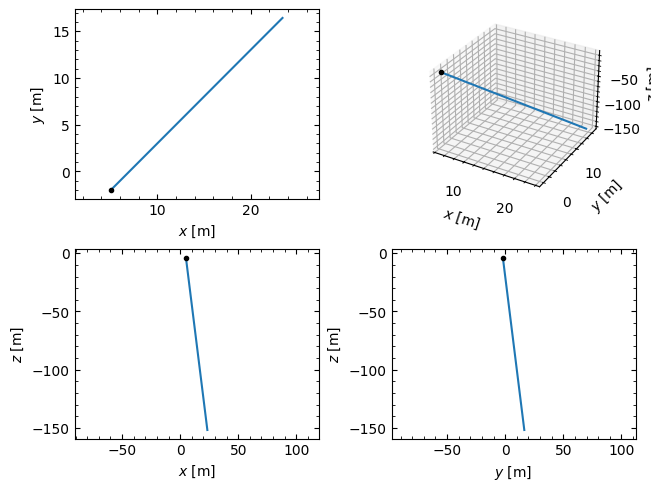

In [5]:
fig, axs = gs.plot.plot_path(path);

## Curved path
The `Path` class also allows for curved borehole trajectories. By default, a polynomial regression of degree $M-1$ passing through all $M$ provided positions is used for the trajectory.

For example, following the last trajectory, we add a position at the middle coordinate ($\xi=0$) and modify the bottom end position to have a deviation $(\Delta x=-2, \Delta y=5)$ from a straight path:

In [6]:
xi = jnp.array([-1., 0., 1.])
(dx, dy) = (-2., 5.)
p = jnp.array(
    [
        [x, y, -D],
        [
            x + 0.5 * L * jnp.sin(beta) * jnp.cos(theta),
            y + 0.5 * L * jnp.sin(beta) * jnp.sin(theta),
            -D - 0.5 * L * jnp.cos(beta)
        ],
        [
            x + L * jnp.sin(beta) * jnp.cos(theta) + dx,
            y + L * jnp.sin(beta) * jnp.sin(theta) + dy,
            -D - L * jnp.cos(beta)
        ],
    ])

path = gs.Path(xi, p)

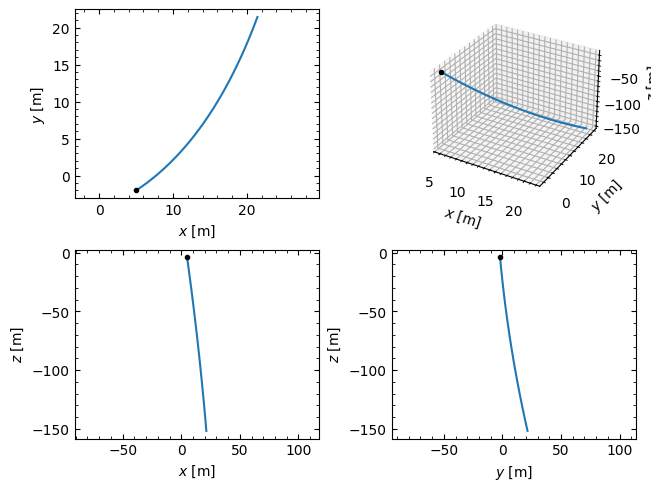

In [7]:
fig, axs = gs.plot.plot_path(path);

## Least squares polynomial regression of a curved path
Like in the case of basis functions, numerical instabilities may appear when approximating a path as a high degree polynomial. High degree polynomial are also prone to oscillations that are not representative of trajectories of real boreholes.

The `order` argument of the `Path` class can be set to use a least squares polynomial regression of the path with a polynomial degree `order - 1`. The starting position of the trajectory (at $\xi=-1$) is constrained.

In [8]:
M = 11
xi = jnp.linspace(-1., 1., num=M)
dx = 3. * jnp.array(np.random.random(M))
dy = 4. * jnp.array(np.random.random(M))
p = jnp.stack(
    [
        x + 0.5 * (xi + 1) * L * jnp.sin(beta) * jnp.cos(theta) + dx,
        y + 0.5 * (xi + 1) * L * jnp.sin(beta) * jnp.sin(theta) + dy,
        -D - 0.5 * (xi + 1) * L * jnp.cos(beta)
    ],
    axis=1
)

path = gs.Path(xi, p, order=3)

C:\Codes\geothermax\geothermsim\path.py:96: RankWarning: Polyfit may be poorly conditioned
  s_coefs = jnp.array(np.polyfit(x_s, s, s_order-1))


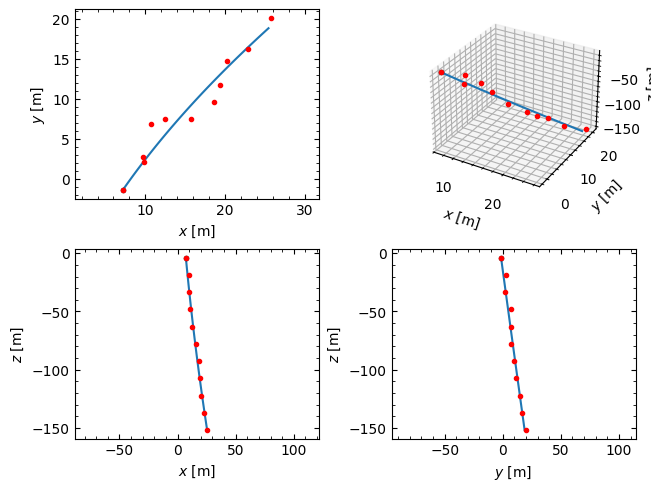

In [9]:
fig, axs = gs.plot.plot_path(path);
axs[0].plot(path.p[:, 0], path.p[:, 1], 'r.');
axs[1].plot(path.p[:, 0], path.p[:, 1], path.p[:, 2], 'r.');
axs[2].plot(path.p[:, 0], path.p[:, 2], 'r.');
axs[3].plot(path.p[:, 1], path.p[:, 2], 'r.');

## Class methods
The `Path` class includes methods to evaluate the position ($\vec{p}(\xi)$) along the trajectory (as shown above), the derivative of the position ($\frac{d\vec{p}}{d\xi}(\xi)$), the norm of the Jacobian ($\| J(\xi) \|$) and the longitudinal position ($s(\xi)$).

In [10]:
xi = jnp.linspace(-1., 1., num=101)
p = path.f_p(xi)
dp_xi = path.f_dp_dxi(xi)
J = path.f_J(xi)
s = path.f_s(xi)

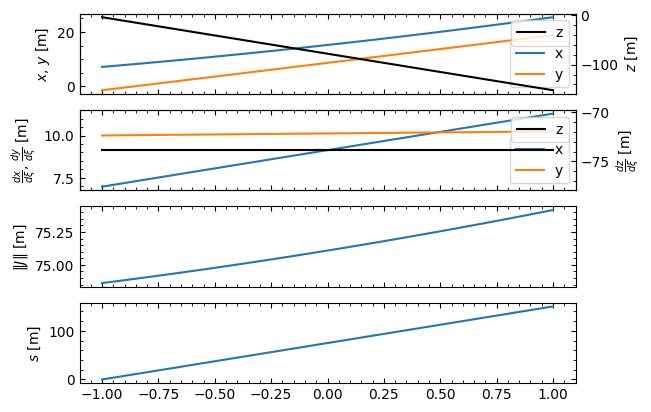

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True)
for ax in axs: gs.plot._format_axis(ax)

# Position (p)
axs[0].plot(xi, p[:, 0], label='x');
axs[0].plot(xi, p[:, 1], label='y');
axs[0].set_ylabel(r'$x$, $y$ [m]')
axs[0].legend()
secax = axs[0].twinx()
secax.tick_params(which='both', direction='in', right=True)
secax.yaxis.set_minor_locator(AutoMinorLocator())
secax.plot(xi, p[:, 2], 'k-', label='z');
secax.set_ylabel(r'$z$ [m]')
secax.legend()

# Derivative of position (dp/dxi)
axs[1].plot(xi, dp_xi[:, 0], label='x');
axs[1].plot(xi, dp_xi[:, 1], label='y');
axs[1].set_ylabel(r'$\frac{dx}{d\xi}$, $\frac{dy}{d\xi}$ [m]')
axs[1].legend()
secax = axs[1].twinx()
secax.tick_params(which='both', direction='in', right=True)
secax.yaxis.set_minor_locator(AutoMinorLocator())
secax.plot(xi, dp_xi[:, 2], 'k-', label='z');
secax.set_ylabel(r'$\frac{dz}{d\xi}$ [m]')
secax.legend()

# Norm of the Jacobian (J)
axs[2].plot(xi, J);
axs[2].set_ylabel(r'$\| J \|$ [m]');

# Longitudinal position (s)
axs[3].plot(xi, s);
axs[3].set_ylabel(r'$s$ [m]');